In [26]:
# Este trecho é para harmonizar a execução com ou sem o Google Colab e o Drive com arquivos sincronizado
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'Colab Notebooks/rnap/PyTorch/'
    import sys
    if base_dir not in sys.path:
        sys.path.append(base_dir)
except ImportError:
    base_dir = ""

Mounted at /content/gdrive


# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision

## Carregamento dos dados do MNIST

In [29]:
dataset_dir = '../data/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [30]:
x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

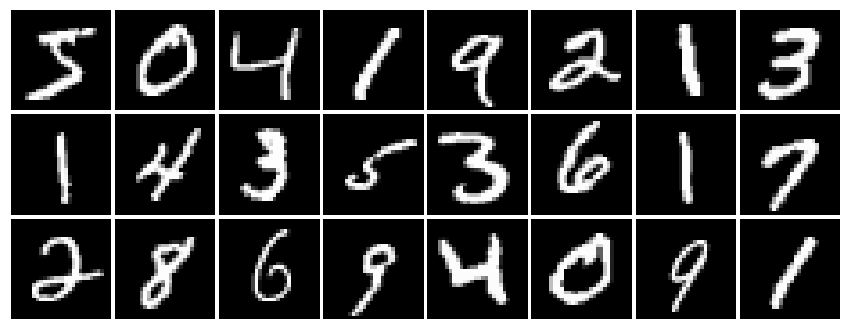

In [31]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


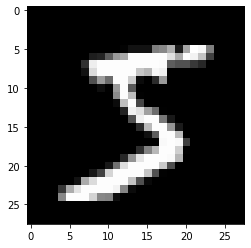

In [32]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [0]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

## Treinamento

### Inicialização dos parâmetros

In [0]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

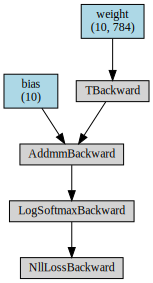

In [35]:
y_pred = model(x_train.view(-1,28*28))
loss = criterion(y_pred, y_train)
from lib.pytorch_visualize import make_dot
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [0]:
losses = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = x_train.view(-1, 28 * 28)
    # Predict da rede
    outputs = model(inputs)

    # calcula a perda
    loss = criterion(outputs, y_train)

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

In [37]:
print('Final loss:', loss.item())

Final loss: 0.26551905274391174


### Visualizando gráfico de perda durante o treinamento

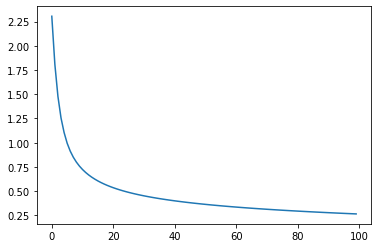

In [38]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [39]:
def predict(model, input_data):
    outputs = model(input_data)
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.939


### Matriz de confusão com dados de treinamento e teste

In [40]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,3,1,0
2,0,1,91,2,0,1,0,1,2,1
3,0,0,0,87,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


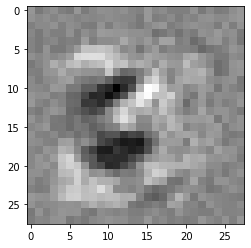

In [41]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

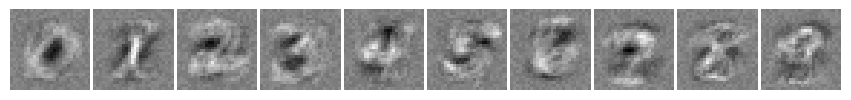

In [42]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoSoftmaxArgmaxNMIST.png" width = "400">

# Atividades

## Exercícios

- 1) Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_hat, após o softmax, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

class: tensor(4)


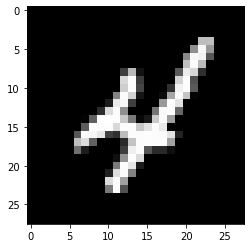

In [43]:
image  = x_train[9]
target = y_train[9]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

- 2) Insira código no laço do treinamento para que no final de cada época, 
     seja impresso: o número da época e a perda e a acurácia

- 3) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

# Aprendizados
